In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())
    

cuda:2


In [2]:
def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
    x = xt[:,0].reshape(-1,1)
    t = xt[:,1].reshape(-1,1)
    y = x*np.cos(5*np.pi*t) + np.power(x*t,3)
    return y.reshape(-1,1)    

In [3]:
pi = np.pi

loss_thresh = 0.1
level = "high"
label = "KG_stanALR_" + level

x = np.linspace(-2,2,500).reshape(-1,1)
t = np.linspace(0,1,500).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

y_true = true_2D_1(xt)
y_true_norm = np.linalg.norm(y_true,2)

#bound_pts_idx = ((X == -5) + (X == 5) + (T == 0)).reshape(-1,)

#xt_bound = xt[bound_pts_idx,:]
#y_bound = y_true[bound_pts_idx,:]


xt_test_tensor = torch.from_numpy(xt).float().to(device)


lb_xt = xt[0]
ub_xt = xt[-1]

In [4]:
def trainingdata(N_I,N_B,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    x_BC1 = np.random.uniform(size = N_I).reshape(-1,1)
    t_BC1 = np.zeros((N_I,1))
    samples = np.hstack((x_BC1,t_BC1))
    xt_BC1 = lb_xt + (ub_xt - lb_xt)*samples
    y_BC1 = true_2D_1(xt_BC1)
    
    x_BC2 = np.zeros((int(N_B/2),1))
    t_BC2 = np.random.uniform(size = int(N_B/2)).reshape(-1,1)
    samples = np.hstack((x_BC2,t_BC2))
    xt_BC2 = lb_xt + (ub_xt - lb_xt)*samples
    y_BC2 = true_2D_1(xt_BC2)
    
    x_BC3 = np.ones((int(N_B/2),1))
    t_BC3 = np.random.uniform(size = int(N_B/2)).reshape(-1,1)
    samples = np.hstack((x_BC3,t_BC3))
    xt_BC3 = lb_xt + (ub_xt - lb_xt)*samples
    y_BC3 = true_2D_1(xt_BC3)
    
    x_NBC = np.random.uniform(size = N_I).reshape(-1,1)
    t_NBC = np.zeros((N_I,1))
    samples = np.hstack((x_NBC,t_NBC))
    xt_NBC = lb_xt + (ub_xt - lb_xt)*samples

    
    xt_BC = np.vstack((xt_BC1,xt_BC2,xt_BC3))
    y_BC = np.vstack((y_BC1,y_BC2,y_BC3))

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    xt_coll = lb_xt + (ub_xt - lb_xt)*samples
    
    xt_coll = np.vstack((xt_coll, xt_BC,xt_NBC)) # append training points to collocation points 

    return xt_coll, xt_BC, y_BC,xt_NBC

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        
        beta_mean = 1.0*torch.ones((50,len(layers)-2))
        beta_std = 0.01*torch.ones((50,len(layers)-2))
        
        self.beta = Parameter(torch.normal(beta_mean,beta_std))
        self.beta.requiresGrad = True
        
        self.lambdas = torch.ones((2,),device = device)
        self.lambda_alpha = 0.1

            
    'foward pass'
    def forward(self,xt):
        if torch.is_tensor(xt) != True:         
            xt = torch.from_numpy(xt)                
        
        ubxt = torch.from_numpy(ub_xt).float().to(device)
        lbxt = torch.from_numpy(lb_xt).float().to(device)
    
                      
        #preprocessing input 
        xt = 2.0*(xt - lbxt)/(ubxt - lbxt) - 1.0
        
        #convert to float
        a = xt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z)
            a = z1 + self.beta[:,i]*z*z1            
        
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xt,y):
                
        loss_bc = self.loss_function(self.forward(xt), y)
                
        return loss_bc
    
    def loss_NBC(self,xt_NBC,N_hat):
        g = xt_NBC.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_NBC.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]        
        dy_dt = y_x_t[:,[1]]
        
        loss_nbc = self.loss_function(dy_dt, N_hat)
                
        return loss_nbc
    
    def loss_PDE(self, xt_coll, f_hat):
        
        g = xt_coll.clone()             
        g.requires_grad = True
        y = self.forward(g) 
        
        
        y_x_t = autograd.grad(y,g,torch.ones([xt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        y_xx_tt = autograd.grad(y_x_t,g,torch.ones(xt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2y_dx2 = y_xx_tt[:,[0]]
        d2y_dt2 = y_xx_tt[:,[1]]    
        

        term1 = -25.0*(pi**2)*(g[:,0].reshape(-1,1))*torch.cos(5.0*pi*g[:,1].reshape(-1,1)) + 6*torch.pow(g[:,0].reshape(-1,1),3)*g[:,1].reshape(-1,1)  
        term1 = term1.reshape(-1,1)
        term2 = 6*torch.pow(g[:,1].reshape(-1,1),3)*g[:,0].reshape(-1,1)
        term2 = term2.reshape(-1,1)
        term3 = torch.pow(g[:,0]*torch.cos(5.0*pi*g[:,1]) + torch.pow(g[:,0]*g[:,1],3),3)
        term3 = term3.reshape(-1,1)
        
        
        f = d2y_dt2 - d2y_dx2 + torch.pow(y,3) - (term1 - term2 + term3)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat):

        loss_BC = self.lambdas[0]*self.loss_BC(xt_BC,y_BC)
        loss_NBC = self.lambdas[1]*self.loss_NBC(xt_NBC,N_hat)
        loss_f = self.loss_PDE(xt_coll,f_hat)
        
        loss_val = loss_BC + loss_f + loss_NBC
        
        return loss_val
    
    def lambda_update(self,xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat):
        loss_bc1 = self.lambdas[0]*self.loss_BC(xt_BC,y_BC)
        loss_bc1.backward()
        bc1_grads = []
        for param in self.parameters():
            bc1_grads.append(param.grad.view(-1))
        bc1_grads = torch.cat(bc1_grads)
        bc1_grads = torch.mean(torch.abs(bc1_grads))      
        
        loss_bc2 = self.lambdas[1]*self.loss_NBC(xt_NBC,N_hat)
        loss_bc2.backward()
        bc2_grads = []
        for param in self.parameters():
            bc2_grads.append(param.grad.view(-1))
        bc2_grads = torch.cat(bc2_grads)
        bc2_grads = torch.mean(torch.abs(bc2_grads))    
    
        loss_f = self.loss_PDE(xt_coll,f_hat)
        loss_f.backward()
        f_grads = []
        for param in self.parameters():
            f_grads.append(param.grad.view(-1))   
        f_grads = torch.cat(f_grads)
        f_grads = torch.max(torch.abs(f_grads))
    
        self.lambdas[0] = (1.0-self.lambda_alpha)*self.lambdas[0] + self.lambda_alpha*f_grads/bc1_grads
        self.lambdas[1] = (1.0-self.lambda_alpha)*self.lambdas[1] + self.lambda_alpha*f_grads/bc2_grads
        
        return None
    
    'test neural network'
    def test(self):
        y_pred = self.forward(xt_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()
   
        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat,seed):
    # x_coll_np_array = colloc_pts(N_f,seed*123)
    # x_coll_train = torch.from_numpy(x_coll_np_array).float().to(device)        
    
    # f_hat = torch.zeros(x_coll_train.shape[0],1).to(device)
#     xt_coll, xt_BC, y_BC = trainingdata(N_I,N_B,N_f,seed*123)
#     xt_coll = torch.from_numpy(xt_coll).float().to(device)
#     xt_BC = torch.from_numpy(xt_BC).float().to(device)
#     y_BC = torch.from_numpy(y_BC).float().to(device)

#     f_hat = torch.zeros(xt_coll.shape[0],1).to(device)
    
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)
    PINN.lambda_update(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat)

In [8]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xt_coll, xt_BC, y_BC, xt_NBC = trainingdata(N_I,N_B,N_f,rep*11)
    xt_coll = torch.from_numpy(xt_coll).float().to(device)
    xt_BC = torch.from_numpy(xt_BC).float().to(device)
    y_BC = torch.from_numpy(y_BC).float().to(device)
    xt_NBC = torch.from_numpy(xt_NBC).float().to(device)
    
    f_hat = torch.zeros(xt_coll.shape[0],1).to(device)
    N_hat = torch.zeros(xt_NBC.shape[0],1).to(device)
    
    loss_np = PINN.loss(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat).cpu().detach().numpy()
    data_update(loss_np)
    for i in range(max_iter):
        if(np.isnan(loss_np) == False):
            train_step(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat,i)
            loss_np = PINN.loss(xt_BC,y_BC,xt_coll,f_hat,xt_NBC,N_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
      
         

    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10 #10
max_iter = 300 #200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 0

N_I = 1000  #Total number of data points for 'y'
N_B = 5000
N_f = 10000 #Total number of collocation points

for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []

    torch.manual_seed(reps*36)

    layers = np.array([2,50,50,50,50,1]) #9 hidden layers
    # layers = np.array([2,50,50,50,50,50,50,50,1])

    PINN = Sequentialmodel(layers,beta_init)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                            max_iter = 20, 
                            max_eval = 30, 
                            tolerance_grad = 1e-8, 
                            tolerance_change = 1e-8, 
                            history_size = 100, 
                            line_search_fn = 'strong_wolfe')




    nan_flag = train_model(max_iter,reps)



    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)


  #print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

KG_stanALR_high
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 27986.424 Test MSE 6.098316267741893 Test RE 1.7841889641709807
1 Train Loss 2413.621 Test MSE 6.274822820442913 Test RE 1.8098251146827669
2 Train Loss 1000.0837 Test MSE 8.247635559371215 Test RE 2.0749164227388173
3 Train Loss 581.6302 Test MSE 9.912676805727122 Test RE 2.2747378299805505
4 Train Loss 349.8472 Test MSE 10.096838075904571 Test RE 2.2957710371555513
5 Train Loss 256.24823 Test MSE 10.173895599042265 Test RE 2.3045148725853695
6 Train Loss 231.61017 Test MSE 10.260212237184405 Test RE 2.3142701252974702
7 Train Loss 201.1693 Test MSE 9.9582438411

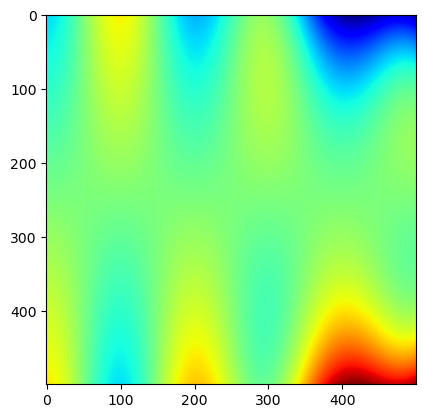

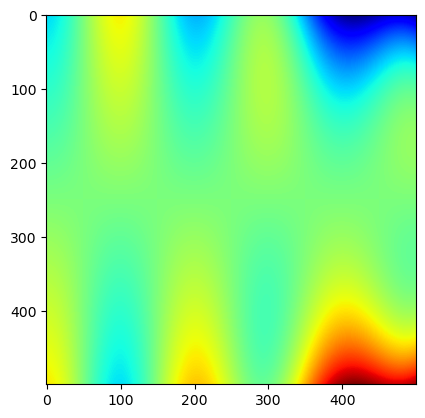

In [10]:
u_pred = PINN.test()
plt.imshow(u_pred.reshape(500,500),cmap = 'jet')
plt.figure()
plt.imshow(y_true.reshape(500,500),cmap = 'jet')

In [11]:
a = np.ones((10,1))
for i in range(10):
    a[i] = test_re_full[i][-1]    
print("a = ",np.nanmean(a))

a =  0.0015863194982764944
